In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!source /content/drive/MyDrive/colab_env/bin/activate

import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

/bin/bash: line 1: /content/drive/MyDrive/colab_env/bin/activate: No such file or directory


In [ ]:
!pip install transformers==4.30.2
# print(transformers.__version__)

In [ ]:
# !pip install spacy_streamlit

In [ ]:
!pip install spacy[transformers]

In [ ]:
!pip install emoji

In [88]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
import os
import re
import json
import spacy
import emoji
import pandas as pd
import transformers
from io import StringIO
import spacy_transformers
# from spacy import displacy
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
# from spacy_streamlit import visualize_textcat
from sklearn.model_selection import train_test_split
from spacy.pipeline.textcat_multilabel import Config, multi_label_cnn_config

In [6]:
%config InlineBackend.figure_format = 'retina'

In [97]:
def get_json(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as file:
        content = json.load(file, strict = False)
    return content

In [15]:
def rmemoji(text):
    return emoji.replace_emoji(text, '').strip()

def emoji2description(text):
    return emoji.replace_emoji(text, replace = lambda chars, data_dict: ' ' + ' '.join(data_dict['zh'].split('_')).strip(':') + ' ')

def remove_punctuation_regex(input_string):
    return re.sub(r'[^\w\s]', '', input_string)

In [ ]:
!python -m spacy download zh_core_web_trf  ## Blank model ## Only Download when opening a new task

In [73]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy')

<h3> Raw dataset </h3>

In [74]:
df = pd.read_csv('./data/Overall_Layer_topic.csv')

In [75]:
print(len(df))
df['text'] = df['text'].replace(' ', '')
df = df[(df['text'] != '') & (df['text'].notnull())]
print(len(df))

121311
121307


### df_rmemoji / df_emoji2desc / df_rmpunc

In [16]:
print(rmemoji(df['text'][0]))
print(emoji2description(df['text'][0]))
print(remove_punctuation_regex(df['text'][0]))

小温加油！美津濃加油
小温加油！美津濃加油 火焰  火焰 
小温加油美津濃加油


#### df_rmemoji

In [62]:
df_rmemoji = df.copy()

print(len(df_rmemoji))
df_rmemoji['text'] = df_rmemoji['text'].astype(str).apply(rmemoji)
df_rmemoji['text'] = df_rmemoji['text'].replace(' ', '')
df_rmemoji = df_rmemoji[(df_rmemoji['text'] != '') & (df_rmemoji['text'].notnull())]
print(len(df_rmemoji))

121307
116280


#### df_emoji2desc

In [61]:
df_emoji2desc = df.copy()

print(len(df_emoji2desc))
df_emoji2desc['text'] = df_emoji2desc['text'].astype(str).apply(emoji2description)
df_emoji2desc['text'] = df_emoji2desc['text'].replace(' ', '')
df_emoji2desc = df_emoji2desc[(df_emoji2desc['text'] != '') & (df_emoji2desc['text'].notnull())]
print(len(df_emoji2desc))

121307
121307


#### df_rmpunc

In [63]:
df_rmpunc = df.copy()

print(len(df_rmpunc))
df_rmpunc['text'] = df_rmpunc['text'].astype(str).apply(remove_punctuation_regex)
df_rmpunc['text'] = df_rmpunc['text'].replace(' ','')
df_rmpunc = df_rmpunc[(df_rmpunc['text'] != '') & (df_rmpunc['text'].notnull())]
print(len(df_rmpunc))

121307
114908


In [76]:
spacy.prefer_gpu()
nlp = spacy.load('zh_core_web_trf')

In [9]:
y = df[['比賽', '加油', '轉播', '閒聊']]
y = y.to_dict('index')

dataset = list(zip(df['text'],[{'cats': cats} for cats in y.values()]))

In [31]:
train_df, test_df = train_test_split(df, train_size = 0.7, random_state = 42)
train_data, test_data = train_test_split(dataset, train_size = 0.7, random_state = 42)

In [ ]:
print('Training data:')
print(train_df['比賽'].sum())
print(train_df['加油'].sum())
print(train_df['轉播'].sum())
print(train_df['閒聊'].sum())
print('\nTesting data:')
print(test_df['比賽'].sum())
print(test_df['加油'].sum())
print(test_df['轉播'].sum())
print(test_df['閒聊'].sum())

In [16]:
config = Config().from_str(multi_label_cnn_config)

text_cat = nlp.add_pipe("textcat_multilabel", config = config)

labels = ['比賽', '加油', '轉播', '閒聊']

for i in labels:
    text_cat.add_label(i)

找出 df_rmemoji 和 df_emoji2desc 有在 test set 裡面的

In [32]:
ind = list(test_df['Unnamed: 0'])

In [55]:
df_rmemoji = df_rmemoji[df_rmemoji['Unnamed: 0'].isin(ind)]
df_emoji2desc = df_emoji2desc[df_emoji2desc['Unnamed: 0'].isin(ind)]
df_rmpunc = df_rmpunc[df_rmpunc['Unnamed: 0'].isin(ind)]

In [37]:
y_rmemoji = df_rmemoji[['比賽', '加油', '轉播', '閒聊']]
y_rmemoji = y_rmemoji.to_dict('index')

dataset_rmemoji = list(zip(df_rmemoji['text'],[{'cats': cats} for cats in y_rmemoji.values()]))

In [60]:
print(dataset_rmemoji[0])
print(len(dataset_rmemoji))

('小温加油！美津濃加油', {'cats': {'比賽': 1, '加油': 1, '轉播': 0, '閒聊': 0}})
34887


In [42]:
y_emoji2desc = df_emoji2desc[['比賽', '加油', '轉播', '閒聊']]
y_emoji2desc = y_emoji2desc.to_dict('index')

dataset_emoji2desc = list(zip(df_emoji2desc['text'],[{'cats': cats} for cats in y_emoji2desc.values()]))

In [59]:
print(dataset_emoji2desc[0])
print(len(dataset_emoji2desc))

('小温加油！美津濃加油 火焰  火焰 ', {'cats': {'比賽': 1, '加油': 1, '轉播': 0, '閒聊': 0}})
36393


In [56]:
y_rmpunc = df_rmpunc[['比賽', '加油', '轉播', '閒聊']]
y_rmpunc = y_rmpunc.to_dict('index')

dataset_rmpunc = list(zip(df_rmpunc['text'],[{'cats': cats} for cats in y_rmpunc.values()]))

In [58]:
print(dataset_rmpunc[0])
print(len(dataset_rmpunc))

('小温加油美津濃加油', {'cats': {'比賽': 1, '加油': 1, '轉播': 0, '閒聊': 0}})
34485


In [80]:
def make_docs(data):
    docs = []
    for text, annotations in data:
        if isinstance(text, str) and isinstance(annotations, dict):
            doc = nlp.make_doc(text)
            doc.cats = annotations.get("cats", {})
            docs.append(doc)
        else:
            print(f"Ignoring invalid data: {text}, {annotations}")
    return docs

In [79]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy/Overall_Layer')

In [20]:
num_texts = len(train_data)
train_docs = make_docs(train_data[:num_texts])
doc_bin_train = DocBin(docs = train_docs)
doc_bin_train.to_disk("./data/train.spacy")

In [21]:
num_texts_val = len(test_data)
valid_docs = make_docs(test_data[:num_texts_val])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid.spacy")

In [81]:
valid_docs = make_docs(dataset_rmemoji[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_rmemoji.spacy")

In [82]:
valid_docs = make_docs(dataset_emoji2desc[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_emoji2desc.spacy")

In [83]:
valid_docs = make_docs(dataset_rmpunc[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_rmpunc.spacy")

### Load base_config.cfg
https://spacy.io/usage/training

<h3> Training data </h3>

比賽 44552, 加油 24239, 轉播 2922, 閒聊 28255


<h3> Testing data </h3>

比賽 19086, 加油 10377, 轉播 1234, 閒聊 12126


In [ ]:
# !python -m spacy init fill-config ./base_config.cfg ./config.cfg

In [22]:
!python -m spacy train config.cfg --output ./output --gpu-id 0

2023-12-19 15:34:49.687165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 15:34:49.687219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 15:34:49.688460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 15:34:50.732259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Saving to output directory: output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
tokenizer_config.json: 100% 29.0/29.0 [00:00<00:00, 155kB/s]
config.json: 100% 624/624 [00:00<00:00, 3.91MB/s]

In [ ]:
data = """E,#,LOSS TRANSFORMER,LOSS TEXTCAT_MULTILABEL,CATS_SCORE,SCORE
0, 0, 0.39, 1.02, 51.87, 0.52
0, 200, 1043.12, 97.57, 92.80, 0.93
0, 400, 303.56, 47.89, 97.18, 0.97
0, 600, 178.48, 32.15, 98.38, 0.98
0, 800, 126.15, 30.29, 98.00, 0.98
1, 1000, 107.72, 23.89, 98.98, 0.99
1, 1200, 75.01, 16.02, 98.85, 0.99
1, 1400, 89.86, 15.21, 99.05, 0.99
1, 1600, 76.18, 17.49, 99.20, 0.99
1, 1800, 71.84, 14.14, 99.28, 0.99
2, 2000, 65.48, 12.96, 99.35, 0.99
2, 2200, 55.02, 11.69, 99.24, 0.99
2, 2400, 60.50, 10.13, 99.17, 0.99
2, 2600, 45.02, 11.14, 99.18, 0.99
2, 2800, 50.65, 10.65, 99.39, 0.99
3, 3000, 44.16, 11.43, 99.41, 0.99
3, 3200, 42.03, 7.15, 99.27, 0.99
3, 3400, 45.62, 9.37, 99.35, 0.99
3, 3600, 37.06, 9.25, 99.32, 0.99
3, 3800, 36.97, 8.40, 99.32, 0.99
4, 4000, 41.03, 7.81, 99.46, 0.99
4, 4200, 38.76, 7.82, 99.39, 0.99
4, 4400, 33.08, 7.03, 99.35, 0.99
4, 4600, 32.93, 7.74, 99.39, 0.99
4, 4800, 38.37, 6.11, 99.38, 0.99
5, 5000, 34.67, 8.54, 99.55, 1.00
5, 5200, 27.16, 5.82, 99.39, 0.99
5, 5400, 32.00, 6.13, 99.52, 1.00
5, 5600, 33.84, 5.52, 99.50, 1.00
5, 5800, 27.78, 6.58, 99.58, 1.00
6, 6000, 31.90, 5.93, 99.50, 0.99
6, 6200, 26.94, 5.29, 99.53, 1.00
6, 6400, 32.88, 4.76, 99.48, 0.99
6, 6600, 25.86, 4.95, 99.36, 0.99
6, 6800, 27.95, 4.39, 99.46, 0.99
7, 7000, 28.92, 6.06, 99.54, 1.00
7, 7200, 24.57, 3.88, 99.04, 0.99
7, 7400, 27.27, 5.15, 99.44, 0.99
"""

df4 = pd.read_csv(StringIO(data))


In [38]:
result = pd.DataFrame({
    'E': df4['E'][:-1].reset_index(drop=True),
    '#': df4['#'][:-1].reset_index(drop=True),
    'LOSS TRANSFORMER': df4['LOSS TRANSFORMER'][1:].reset_index(drop=True),
    'LOSS TEXTCAT_MULTILABEL': df4['LOSS TEXTCAT_MULTILABEL'][1:].reset_index(drop=True),
    'CATS_SCORE': df4['CATS_SCORE'][:-1].reset_index(drop=True),
    'SCORE': df4['SCORE'][:-1].reset_index(drop=True)
})

result.to_csv('Overall_Layer_training_result_1220.csv', index = False)

<Figure size 1600x800 with 0 Axes>

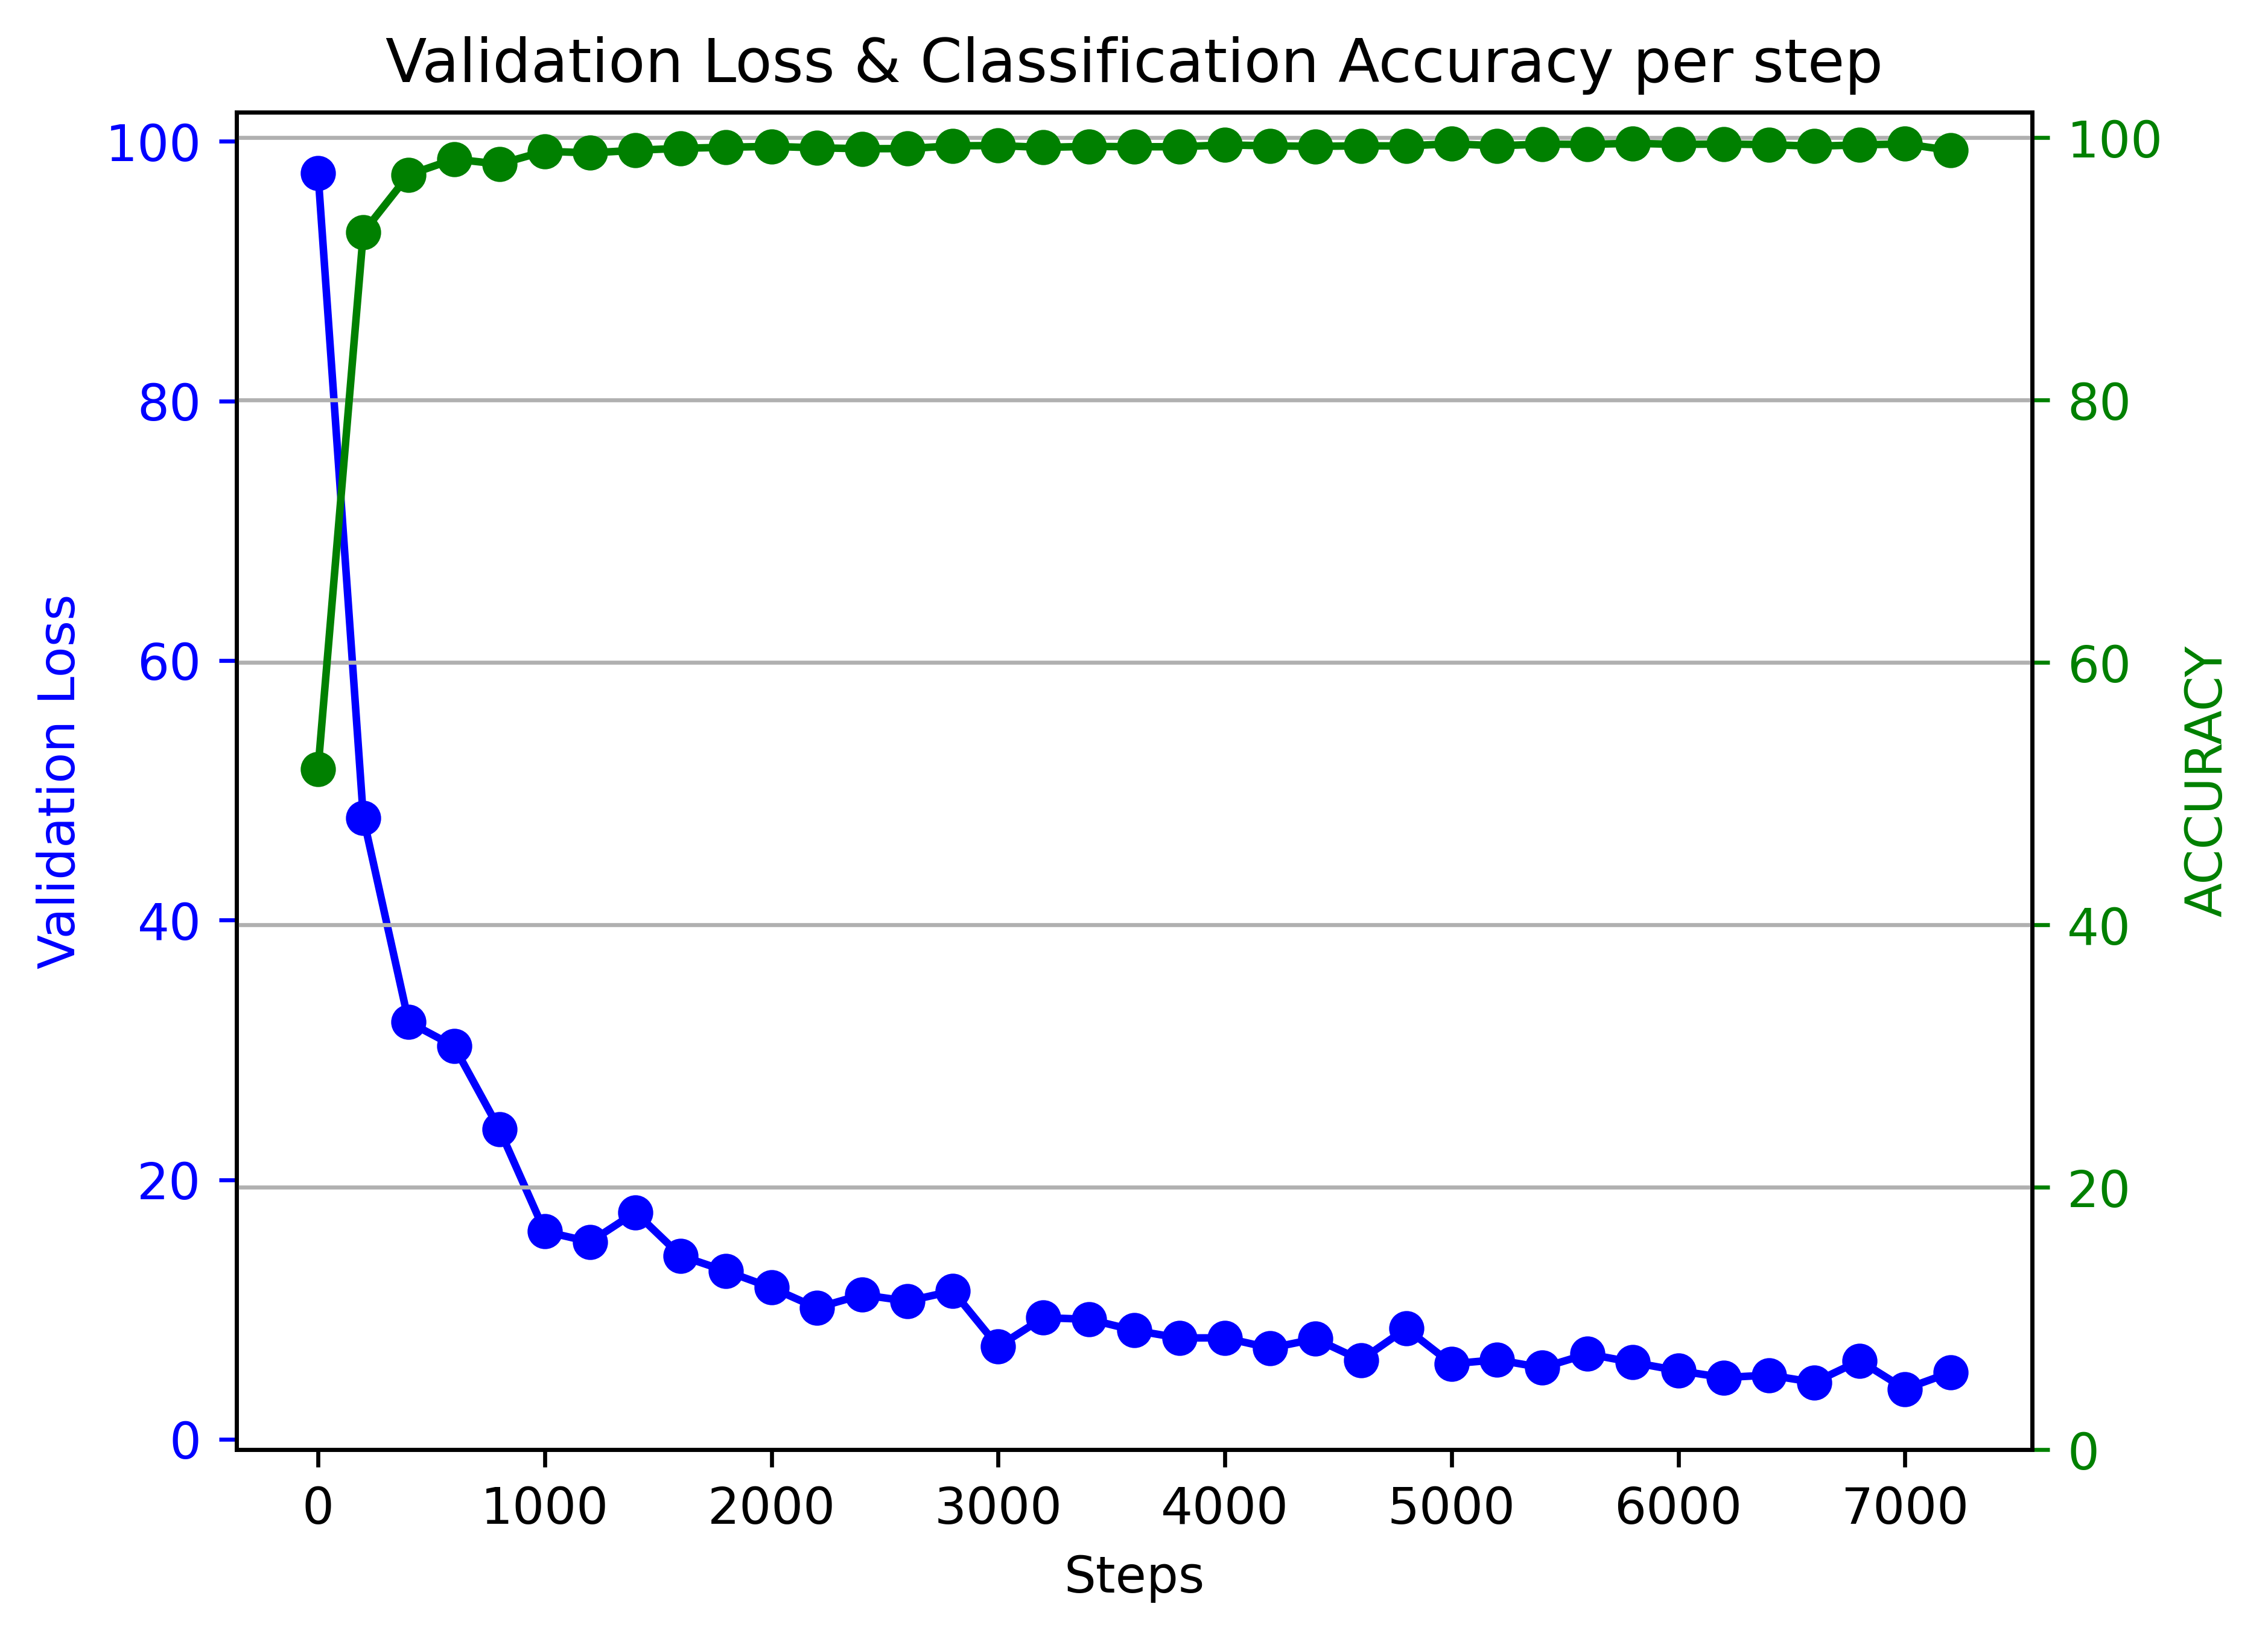

In [37]:
plt.figure(figsize = (16, 8))
fig, ax1 = plt.subplots(dpi = 300)

ax1.plot(result['#'], result['LOSS TEXTCAT_MULTILABEL'],  label = 'Validation Loss', marker = 'o', color = 'blue')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Validation Loss', color = 'blue')
ax1.set_yticks(range(0, 110, 20))
ax1.tick_params('y', colors = 'blue')

ax2 = ax1.twinx()
ax2.plot(result['#'], result['CATS_SCORE'], label = 'SCORE', marker = 'o', color = 'green')
ax2.set_ylabel('ACCURACY', color = 'green')
ax2.set_yticks(range(0, 110, 20))
ax2.tick_params('y', colors = 'green')

plt.title('Validation Loss & Classification Accuracy per step')
plt.grid(True)
plt.show()

In [ ]:
clf = spacy.load('/content/drive/MyDrive/Capstone/Spacy/Overall_Layer/output/model-best')

In [86]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy/Overall_Layer')

In [89]:
!python -m spacy evaluate output/model-best/ --output ./output/metrics.json ./data/valid.spacy --gpu-id 0

2023-12-20 02:38:23.331998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 02:38:23.332049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 02:38:23.333299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 02:38:24.376982: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.58 
SPEED                 3165  


=========================== Textcat F (per label) =======

In [90]:
!python -m spacy evaluate output/model-best/ --output ./output/metrics_rmemoji.json ./data/valid_rmemoji.spacy --gpu-id 0

2023-12-20 02:41:01.540224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 02:41:01.540281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 02:41:01.542019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 02:41:03.187507: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   98.85 
SPEED                 4184  


=========================== Textcat F (per label) =======

In [91]:
!python -m spacy evaluate output/model-best/ --output ./output/metrics_emoji2desc.json ./data/valid_emoji2desc.spacy --gpu-id 0

2023-12-20 02:42:43.752183: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 02:42:43.752251: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 02:42:43.753573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 02:42:44.851430: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.04 
SPEED                 4481  


=========================== Textcat F (per label) =======

In [93]:
!python -m spacy evaluate output/model-best/ --output ./output/metrics_rmpuncs.json ./data/valid_rmpunc.spacy --gpu-id 0

2023-12-20 02:45:10.101978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 02:45:10.102029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 02:45:10.103237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 02:45:11.858799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   98.80 
SPEED                 3650  


=========================== Textcat F (per label) =======

In [94]:
os.chdir('./output')

In [98]:
score = get_json('./metrics.json')
score_rmemoji = get_json('./metrics_rmemoji.json')
score_emoji2desc = get_json('./metrics_emoji2desc.json')
score_rmpunc = get_json('./metrics_rmpuncs.json')

In [110]:
p = ['cats_score', 'cats_macro_p', 'cats_macro_r', 'cats_macro_f']

performance_raw = pd.DataFrame({
    'SCORE': score[p[0]],
    'MARCO_P': score[p[1]],
    'MARCO_R': score[p[2]],
    'MARCO_F1': score[p[3]]
}, index = ['RAW'])

performance_rmemoji = pd.DataFrame({
    'SCORE': score_rmemoji[p[0]],
    'MARCO_P': score_rmemoji[p[1]],
    'MARCO_R': score_rmemoji[p[2]],
    'MARCO_F1': score_rmemoji[p[3]]
}, index = ['Remove Emoji'])

performance_emoji2desc = pd.DataFrame({
    'SCORE': score_emoji2desc[p[0]],
    'MARCO_P': score_emoji2desc[p[1]],
    'MARCO_R': score_emoji2desc[p[2]],
    'MARCO_F1': score_emoji2desc[p[3]]
}, index = ['Emoji to Description'])

performance_rmpunc = pd.DataFrame({
    'SCORE': score_rmpunc[p[0]],
    'MARCO_P': score_rmpunc[p[1]],
    'MARCO_R': score_rmpunc[p[2]],
    'MARCO_F1': score_rmpunc[p[3]]
}, index = ['Remove Punctuation'])

performance = pd.concat([performance_raw, performance_rmemoji, performance_emoji2desc, performance_rmpunc])
performance.index.name = 'METHOD'

In [111]:
performance.style.highlight_max(axis = 0, color = 'red').highlight_min(axis = 0, color = 'lightblue')

,SCORE,MARCO_P,MARCO_R,MARCO_F1
METHOD,,,,
RAW,0.995770,0.978323,0.967371,0.972603
Remove Emoji,0.988550,0.983733,0.977516,0.980510
Emoji to Description,0.990372,0.967983,0.966062,0.966781
Remove Punctuation,0.988023,0.980730,0.976893,0.978661


In [112]:
performance.to_csv('prf_cf_emoji.csv')

In [102]:
cats_f_per_type = score['cats_f_per_type']
df_cats_f_per_type = pd.DataFrame(cats_f_per_type).T
df_cats_f_per_type = df_cats_f_per_type.rename(columns = {'p': 'PRECISION', 'r': 'RECALL', 'f': 'F1'})

df_cats_f_per_type.index.name = 'CATEGORY'

In [103]:
df_cats_f_per_type.style.highlight_max(axis = 0, color = 'red').highlight_min(axis = 0, color = 'lightblue')

,PRECISION,RECALL,F1
CATEGORY,,,
比賽,0.967439,0.991617,0.979379
加油,0.986960,0.940927,0.963394
轉播,0.970305,0.979741,0.975000
閒聊,0.988587,0.957199,0.972640


In [104]:
df_cats_f_per_type.to_csv('prf_cf_cats.csv')

In [105]:
cats_f_per_type_score = score['cats_f_per_type']
cats_f_per_type_rmemoji = score_rmemoji['cats_f_per_type']
cats_f_per_type_emoji2desc = score_emoji2desc['cats_f_per_type']
cats_f_per_type_rmpunc = score_rmpunc['cats_f_per_type']

df_cats_f_per_type_score = pd.DataFrame(cats_f_per_type_score).T
df_cats_f_per_type_rmemoji = pd.DataFrame(cats_f_per_type_rmemoji).T
df_cats_f_per_type_emoji2desc = pd.DataFrame(cats_f_per_type_emoji2desc).T
df_cats_f_per_type_rmpunc = pd.DataFrame(cats_f_per_type_rmpunc).T

df_cats_f_per_type_score = df_cats_f_per_type_score.rename(columns={'f': 'RAW'})
df_cats_f_per_type_rmemoji = df_cats_f_per_type_rmemoji.rename(columns={'f': 'Remove Emoji'})
df_cats_f_per_type_emoji2desc = df_cats_f_per_type_emoji2desc.rename(columns={'f': 'Emoji to Description'})
df_cats_f_per_type_rmpunc = df_cats_f_per_type_rmpunc.rename(columns={'f': 'Remove punctuation'})

df_cats = pd.concat([df_cats_f_per_type_score[['RAW']], df_cats_f_per_type_rmemoji[['Remove Emoji']], df_cats_f_per_type_emoji2desc[['Emoji to Description']], df_cats_f_per_type_rmpunc[['Remove punctuation']]], axis = 1)
df_cats.index.name = 'F1 score'

In [106]:
df_cats.style.highlight_max(axis = 1, color = 'red').highlight_min(axis = 1, color = 'lightblue')

,RAW,Remove Emoji,Emoji to Description,Remove punctuation
F1 score,,,,
比賽,0.979379,0.987248,0.979171,0.986319
加油,0.963394,0.973778,0.946889,0.972925
轉播,0.975000,0.979327,0.979741,0.975413
閒聊,0.972640,0.981688,0.961322,0.979985


In [107]:
df_cats.to_csv('f1_cf_cats_emoji.csv')